In [95]:
import locale

# This is to fix a Google Colab error that for some reasons, Google Colab does not set the prefer encoding to UTF-8 initially.
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install rouge
!pip install shap
!pip install transformers
!pip install spacy
!pip install pysummarization

In [64]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import math 
import nltk
import re 
import spacy
import rouge
import shap
import nltk
import matplotlib.pyplot as plt
import graphviz
import collections
import pydotplus

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Masking, Reshape, TimeDistributed, Bidirectional, Dropout, Layer
from tensorflow.keras.models import Model, clone_model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import sparse_categorical_crossentropy
from nltk.stem import WordNetLemmatizer
from rouge import Rouge
from tensorflow.keras.models import load_model
from keras.regularizers import l2
from utils import *
from textblob import TextBlob
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image


In [101]:
def split_text_to_sentences(text):
    doc = nlp(text)

    sentences = [sentence.text for sentence in doc.sents]

    return sentences

def clean_text(text):
  text = text.strip()
  text = text.lower()

  lemmatizer = WordNetLemmatizer()
  words = text.split()
  words = [lemmatizer.lemmatize(word) for word in words]
  text = ' '.join(words)

  return text

def clean_dataset(dataset):
    for category in dataset: 
        df = dataset[category]
        df["Content"] = df["Content"].apply(lambda content: clean_text(content))
        df["Summary"] = df["Summary"].apply(lambda summary: clean_text(summary))

def downsize_dataset(dataset):
    for category in dataset:
        df = dataset[category]
        df = df[df.apply(lambda x: 
                         len(x['Content'].strip()) <= 4500 and 
                         len(x['Summary'].strip()) <= 3000, axis=1)]
        dataset.update({category: df})

In [61]:
nltk.download('omw-1.4')
nltk.download("wordnet")
nltk.download('brown')
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [102]:
learning_rate = 0.002
num_iterations = 30
max_number_of_sentences = 40 
max_words_per_sentence = 150
lstm_size = 128
vocab_size = 10000
batch_size = 32
test_size = 0.33 
threshold = 0.5
l2_regulizer = 0.15

In [18]:
business_pickle = "train_df_label_business.pickle"
entertainment_pickle = "train_df_label_entertainment.pickle"
politics_pickle = "train_df_label_politics.pickle"
sport_pickle = "train_df_label_sport.pickle"
tech_pickle = "train_df_label_tech.pickle"

In [20]:
business_dataset = pd.read_pickle(business_pickle)
entertainment_dataset = pd.read_pickle(entertainment_pickle)
politics_dataset = pd.read_pickle(politics_pickle)
sport_dataset = pd.read_pickle(sport_pickle)
tech_dataset = pd.read_pickle(tech_pickle)

In [21]:
train_business_dataset, test_business_dataset = train_test_split(business_dataset, test_size=test_size, random_state=42)
train_entertainment_dataset, test_entertainment_dataset = train_test_split(entertainment_dataset, test_size=test_size, random_state=42)
train_politics_dataset, test_politics_dataset = train_test_split(politics_dataset, test_size=test_size, random_state=42)
train_sport_dataset, test_sport_dataset = train_test_split(sport_dataset, test_size=test_size, random_state=42)
train_tech_dataset, test_tech_dataset = train_test_split(tech_dataset, test_size=test_size, random_state=42)

In [22]:
train_dataset = {
    "business": train_business_dataset, 
    "entertainment": train_entertainment_dataset, 
    "politics": train_politics_dataset, 
    "sport": train_sport_dataset, 
    "tech": train_tech_dataset, 
}

test_dataset = {
    "business": test_business_dataset, 
    "entertainment": test_entertainment_dataset, 
    "politics": test_politics_dataset, 
    "sport": test_sport_dataset, 
    "tech": test_tech_dataset, 
}

In [24]:
downsize_dataset(train_dataset)
downsize_dataset(test_dataset)

In [26]:
clean_dataset(train_dataset)
clean_dataset(test_dataset)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
def get_tokenizer(texts):
    tokenizer = Tokenizer(num_words = 10000)
    tokenizer.fit_on_texts(texts)
    return tokenizer

In [30]:
all_texts = []
for category in train_dataset.keys():
    for text in train_dataset[category]["Content"]:
        all_texts.append(text) 
            
    for text in train_dataset[category]["Summary"]:
        all_texts.append(text)

tokenizer = get_tokenizer(all_texts)

In [31]:
model = load_model("model.h5")

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 40, 256)          285696    
 l)                                                              
                                                                 
 dense (Dense)               (None, 40, 1)             257       
                                                                 
Total params: 285,953
Trainable params: 285,953
Non-trainable params: 0
_________________________________________________________________


In [46]:
def convert_texts_to_vectors_of_sequences(texts, max_number_of_sentences, max_words_per_sentence, tokenizer):
    texts_tokenized = np.zeros((len(texts), max_number_of_sentences, max_words_per_sentence))
    
    for i, text in enumerate(texts):
        sentences = split_text_to_sentences(text)
        num_sentences = min(len(sentences), max_number_of_sentences)
        for j in range(num_sentences):
            sentence = sentences[j].strip()

            sentence_words = tokenizer.texts_to_sequences([sentence])[0]

            sentence_words = pad_sequences([sentence_words], maxlen=max_words_per_sentence, padding='post', truncating='post')[0]
            
            texts_tokenized[i, j, :] = sentence_words
    
        if num_sentences < max_number_of_sentences:
            texts_tokenized[i, num_sentences:, :] = np.zeros((max_number_of_sentences - num_sentences , max_words_per_sentence))
            
    return texts_tokenized

def calculate_rouge_score(predicted_summary, reference_summary):
    rouge = Rouge()
    scores = rouge.get_scores(predicted_summary, reference_summary, avg=True)
    return scores['rouge-1']['f']

In [53]:
# We need to keep track the label of each sentence(chosen or not chosen). However, when processing data, we have to pad empty sentences to the 
# original text to make sure all texts have the same length so all_labels_without_empty_sentences are the labels (chosen or not chosen) of every sentences
# that are not empty sentences whereas all_labels_with_empty_sentences are the labels of every sentences including empty sentences
all_non_empty_sentences = []
all_labels_without_empty_sentences = []
all_labels_with_empty_sentences = []

# This list is to store the index of NON-EMPTY sentence in the text. For example: "Hello world ! My name is John". "Hello world" sentence
# index is 0 where "My name is John" index is 1. 
sentence_indexes = []

number_of_sentences_processing = 0 

number_of_texts = 0

sum_rouge_score = 0 

In [54]:
for category in test_dataset.keys():
    df = test_dataset[category]

    X = convert_texts_to_vectors_of_sequences(df["Content"], max_number_of_sentences, max_words_per_sentence, tokenizer)
    y_pred = model.predict(X)
    # y_pred will look something like this: [[0.67, 0.52, 0.33, 0.15], [0.23, 0.48, 0.57, 0.1]]. Each 1D array is the text that needs to be
    # summarized and each element in that list indicates the probability of that sentence being kept in the final summary.

    # chosen_indexes are indexes of the sentences that will be kept in the final summary
    chosen_indexes_for_texts = []
    for prob_list in y_pred:
        chosen_indexes_for_current_text = []

        for i, prob in enumerate(prob_list):
            cur_label = False

            if prob > threshold:
               cur_label = True 
               chosen_indexes_for_current_text.append(i)
              
            all_labels_with_empty_sentences.append(cur_label)

            number_of_sentences_processing += 1 

        chosen_indexes_for_texts.append(chosen_indexes_for_current_text)
    
    for i, chosen_indexes in enumerate(chosen_indexes_for_texts):
        sentences = split_text_to_sentences(df["Content"].iloc[i]) # non_empty sentences only
        generated_summary = []

        for index, sentence in enumerate(sentences):
            all_non_empty_sentences.append(sentence)

            sentence_indexes.append(index)

            cur_label = False 
            if index in chosen_indexes:
                generated_summary.append(sentence)
                cur_label = True 

            all_labels_without_empty_sentences.append(cur_label)

        generated_summary = '. '.join(generated_summary)
        number_of_texts += 1 
        # If the summary is empty we consider the rouge score to be 0 
        if len(generated_summary) == 0:
            continue

        real_summary = df["Summary"].iloc[i]
        rouge_score = calculate_rouge_score(generated_summary, real_summary)  
        sum_rouge_score += rouge_score 

print(sum_rouge_score / number_of_texts)
print(len(all_labels_with_empty_sentences), len(all_labels_without_empty_sentences))
        

4/4 [==============================] - 0s 38ms/step
0.5376955916925653
28080 11870


In [55]:
def get_key_phrases(text):
    blob = TextBlob(text)

    phrases = blob.noun_phrases

    return list(phrases)

In [56]:
def get_sentiment_scores(sentence):
    sentiment = TextBlob(sentence).sentiment.polarity
    return sentiment

In [57]:
def count_named_entities(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    named_entities = set([ent.text for ent in doc.ents if ent.label_ != ''])
    return len(named_entities)

In [58]:
def convert_sentence_to_vector_of_features(sentence):
    sentence_length = len(sentence)
    number_of_words = len(sentence.split(' '))
    number_of_phrases = len(get_key_phrases(sentence))
    sentiment = get_sentiment_scores(sentence)
    number_of_named_entities = count_named_entities(sentence)
    
    return [sentence_length, number_of_words, number_of_phrases, sentiment, number_of_named_entities] 


In [62]:
# Convert all_sentences to a list of features
X = []
for i in range(2000):
    sentence = all_non_empty_sentences[i]

    features = convert_sentence_to_vector_of_features(sentence)
    features.append(sentence_indexes[i]) 

    X.append(features)

In [65]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
y = all_labels_without_empty_sentences[:len(X)]
lr = LinearRegression()
lr.fit(X_normalized, y)

LinearRegression()

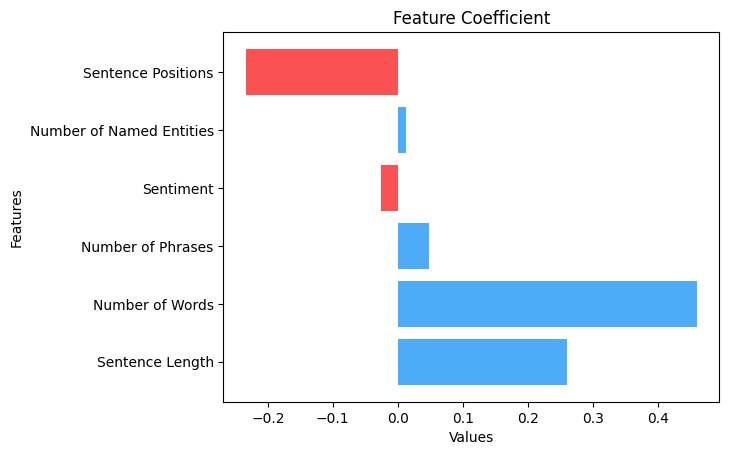

In [66]:
import matplotlib.pyplot as plt
import numpy as np

feature_names = ['Sentence Length', 'Number of Words', 'Number of Phrases', 'Sentiment', 'Number of Named Entities', 'Sentence Positions']
feature_values = lr.coef_

colors = ['#4dabf7' if val > 0 else '#fa5252' for val in feature_values]

fig, ax = plt.subplots()
ax.barh(feature_names, feature_values, color=colors)

ax.set_title("Feature Coefficient")
ax.set_xlabel("Values")
ax.set_ylabel("Features")

plt.show()


In [67]:
clf = DecisionTreeClassifier(max_depth=8, max_leaf_nodes=8)

feature_names = ["sentence length", "number of words", "number of phrases", "sentiment", "number of named entities", "sentence position"]
class_names = ["not chosen", "chosen"]
clf.fit(X, y)

DecisionTreeClassifier(max_depth=8, max_leaf_nodes=8)

In [68]:
#Code to draw the decision tree 

dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=feature_names,  
                           class_names=class_names,  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 

colors = ('#ff8787', '#69db7c')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        label = dest.get_label()
        if label is not None:
          class_name = label.split('class = ')[1].split('\\n')[0][:-1]
          if class_name == class_names[0]: 
             dest.set_fillcolor(colors[0])
          else:
             dest.set_fillcolor(colors[1])

graph.write_png('tree.png')

True

In [69]:
def rearrange_sentences(text):
    sentences = split_text_to_sentences(text)
    
    sentences = [s.strip() for s in sentences]
    
    shuffled_sentences = random.sample(sentences, len(sentences))
    
    original_sentence_indexes = {}
    for i, sentence in enumerate(shuffled_sentences):
        original_sentence_indexes[i] = sentences.index(sentence)
    
    new_text = ". ".join(shuffled_sentences)
    
    return new_text, original_sentence_indexes

In [73]:
def replace_phrases(text, phrases):
    # Phrases that have been shuffled will not be shuffled again.
    available_phrases = phrases[:]

    for phrase in phrases:
        if phrase not in available_phrases: continue

        random_phrase = random.sample(available_phrases, len(available_phrases)).pop(0)

        old_phrase = phrase 
        new_phrase = random_phrase 

        new_text = text.replace(old_phrase, "temp")
        new_text = new_text.replace(new_phrase, old_phrase)
        new_text = new_text.replace("temp", new_phrase)

        text = new_text

        # old_phrase and new_phrase might be the same
        if old_phrase in available_phrases:
          available_phrases.remove(old_phrase)
        
        if new_phrase in available_phrases:
          available_phrases.remove(new_phrase)

    return text

text = "I am an iphone researcher from the United States. I am here to introduce you about our new Mac Mini. It is much better than Microsoft computer"
phrases = ["iphone researcher", "United States", "Mac Mini", "Microsoft computer"]
new_text = replace_phrases(text, phrases)
print(new_text)

I am an iphone researcher from the Microsoft computer. I am here to introduce you about our new Mac Mini. It is much better than United States


In [74]:
# Shufle phrases in the sentences and see the result 
sum_rouge_score = 0 
number_of_processing_sentences = 0 
number_of_correct_sentences = 0 #Correct here meaning that the new label is still the same as the old label 

for category in test_dataset.keys():
    df = test_dataset[category]

    # Shuffle phrases in the original text first 
    new_contents = []
    for content in df["Content"]:
      phrases = get_key_phrases(content)
      new_content = replace_phrases(content, phrases)
      new_contents.append(new_content) 
    
    X = convert_texts_to_vectors_of_sequences(new_contents, max_number_of_sentences, max_words_per_sentence, tokenizer)
    y_pred = model.predict(X)

    for i, prob_list in enumerate(y_pred):
        for j, prob in enumerate(prob_list):
            new_label = False 

            if prob > threshold:
              new_label = True 
            
            old_label = all_labels_with_empty_sentences[number_of_processing_sentences]
            number_of_correct_sentences += (old_label == new_label)
            number_of_processing_sentences += 1 

print(number_of_correct_sentences / number_of_processing_sentences)

4/4 [==============================] - 0s 34ms/step
0.8476495726495726


In [77]:
# Rearrange sentences and see the result 
sum_rouge_score = 0 
number_of_correct_sentences = 0 # Correct here meaning that the new label is still the same as the old label 
all_new_labels_without_empty_sentences = []

for category in test_dataset.keys():
    df = test_dataset[category]

    # Rearrange the content and keep the original_indexes
    new_contents = []
    original_indexes_list = []
    for content in df["Content"]:
      new_content, original_indexes = rearrange_sentences(content)
      new_contents.append(new_content) 
      original_indexes_list.append(original_indexes)

    X = convert_texts_to_vectors_of_sequences(new_contents, max_number_of_sentences, max_words_per_sentence, tokenizer)
    y_pred = model.predict(X)

    for i, prob_list in enumerate(y_pred):
        new_labels = [False for _ in range(len(original_indexes_list[i]))] 

        for j, prob in enumerate(prob_list):
            if (j + 1 ) not in original_indexes_list[i]: continue 

            if prob > threshold:
               original_index = original_indexes_list[i][j + 1]
               new_labels[original_index] = True 

        all_new_labels_without_empty_sentences += new_labels

for i, new_label in enumerate(all_new_labels_without_empty_sentences):
    old_label = all_labels_without_empty_sentences[i]
    number_of_correct_sentences += (new_label == old_label)

number_of_sentences = len(all_labels_without_empty_sentences)
print(number_of_correct_sentences / number_of_sentences)
    
        

4/4 [==============================] - 0s 36ms/step
0.6184498736310026


In [91]:
# This text will be used by SHAP to explain
df = test_dataset["tech"]
text = df["Content"].iloc[44]
text
X = convert_texts_to_vectors_of_sequences([text], max_number_of_sentences, max_words_per_sentence, tokenizer)[0]
y_pred = generate_prob_for_each_sentences(X)

1/1 [==============================] - 0s 36ms/step


In [92]:
# We will use predicted_summary later
predicted_summary = []
chosen_indexes = []
sentences = split_text_to_sentences(text)
for j, prob in enumerate(y_pred):
    if prob > threshold and j < len(sentences):
        chosen_indexes.append(j)
        predicted_summary.append(sentences[j])

predicted_summary = '.'.join(predicted_summary)

In [ ]:
index_word = {v: k for k, v in tokenizer.word_index.items()}

In [86]:
X_original = []
for sequence in X: 
    sentence = []
    for index in sequence:
        if index in index_word:
            word = index_word[index]
            sentence.append(word)
        else:
            sentence.append('')
    X_original.append(sentence)

In [ ]:
X_original

In [79]:
def generate_prob_for_each_sentences(X):
    x1, x2 = X.shape
    y_pred = model.predict(X.reshape(1, x1, x2))
    y_pred = np.squeeze(y_pred, axis=2)
    return y_pred[0]

In [81]:
baseline = np.zeros((max_number_of_sentences, max_words_per_sentence))

In [82]:
explainer = shap.KernelExplainer(generate_prob_for_each_sentences, baseline)

1/1 [==============================] - 0s 26ms/step


In [ ]:
shap_values = explainer.shap_values(X)

In [88]:
key_phrases = get_key_phrases(text)
min_phrase_length = 1e9 
max_phrase_length = 0 

for phrase in key_phrases:
    min_phrase_length = min(min_phrase_length, len(phrase.split()))
    max_phrase_length = max(max_phrase_length, len(phrase.split()))


In [89]:
sum_phrases_shap_values = dict() # The total shapley value of each phrases in the text.

for i, sentence in enumerate(X_original):
    for phrase_length in range(min_phrase_length, max_phrase_length + 1):
        for j in range(0, len(sentence) - phrase_length + 1):
            phrase_shap_value = 0
            phrase = []
            for k in range(j, j + phrase_length):
                phrase.append(X_original[i][k])
                phrase_shap_value += shap_values[i][k]
            phrase = " ".join(phrase) 
            if phrase not in sum_phrases_shap_values:
               sum_phrases_shap_values[phrase] = (0, 0)
            
            cur_sum, cur_count = sum_phrases_shap_values[phrase]
            cur_sum += phrase_shap_value 
            cur_count += 1 
            sum_phrases_shap_values[phrase] = (cur_sum, cur_count)


In [93]:
avg_key_phrases_shap_values = dict()
key_phrase_count = dict()

for phrase in sum_phrases_shap_values:
    if phrase == '' or phrase == ' ': continue
    if len(phrase) >= 2 and (phrase not in key_phrases or phrase not in predicted_summary):
        continue
    sum, count = sum_phrases_shap_values[phrase]
    avg_key_phrases_shap_values[phrase] = sum / count 
    key_phrase_count[phrase] = count

In [96]:
import matplotlib
import matplotlib.font_manager as fm

# Download the font file
!wget "https://fonts.google.com/download?family=Poppins" -O poppins.zip
!unzip poppins.zip -d poppins

# Register the font
fm.fontManager.addfont('poppins/Poppins-Regular.ttf')

# set Poppins as the default font for all plots
matplotlib.rcParams['font.family'] = 'Poppins'

--2023-04-14 05:17:58--  https://fonts.google.com/download?family=Poppins
Resolving fonts.google.com (fonts.google.com)... 108.177.13.138, 108.177.13.101, 108.177.13.113, ...
Connecting to fonts.google.com (fonts.google.com)|108.177.13.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘poppins.zip’

poppins.zip             [ <=>                ]   1.29M  --.-KB/s    in 0.06s   

2023-04-14 05:17:58 (21.3 MB/s) - ‘poppins.zip’ saved [1351005]

Archive:  poppins.zip
  inflating: poppins/OFL.txt         
  inflating: poppins/Poppins-Thin.ttf  
  inflating: poppins/Poppins-ThinItalic.ttf  
  inflating: poppins/Poppins-ExtraLight.ttf  
  inflating: poppins/Poppins-ExtraLightItalic.ttf  
  inflating: poppins/Poppins-Light.ttf  
  inflating: poppins/Poppins-LightItalic.ttf  
  inflating: poppins/Poppins-Regular.ttf  
  inflating: poppins/Poppins-Italic.ttf  
  inflating: poppins/Poppins-Medium.ttf  
  inflating: poppins/Popp

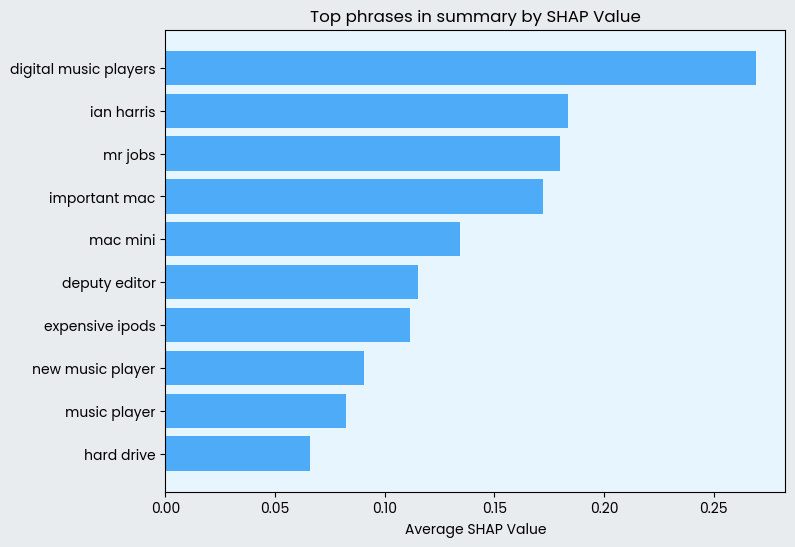

In [97]:
# Draw the top 10 phrases with highest shap value
import matplotlib.pyplot as plt

top_phrases = sorted(avg_key_phrases_shap_values.items(), key=lambda x: x[1], reverse=True)[:10]
top_phrases = [(phrase, value) for phrase, value in top_phrases if value > 0]
top_phrases.reverse() 

phrases = [w[0] for w in top_phrases ]
plotted_phrases_shap_values = [w[1] for w in top_phrases]
colors =  ['#4dabf7']*len(top_phrases)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(phrases, plotted_phrases_shap_values, color=colors)

ax.set_xlabel('Average SHAP Value')
ax.set_title('Top phrases in summary by SHAP Value')
fig.set_facecolor('#e9ecef')
ax.set_facecolor('#e7f5ff')

plt.show()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


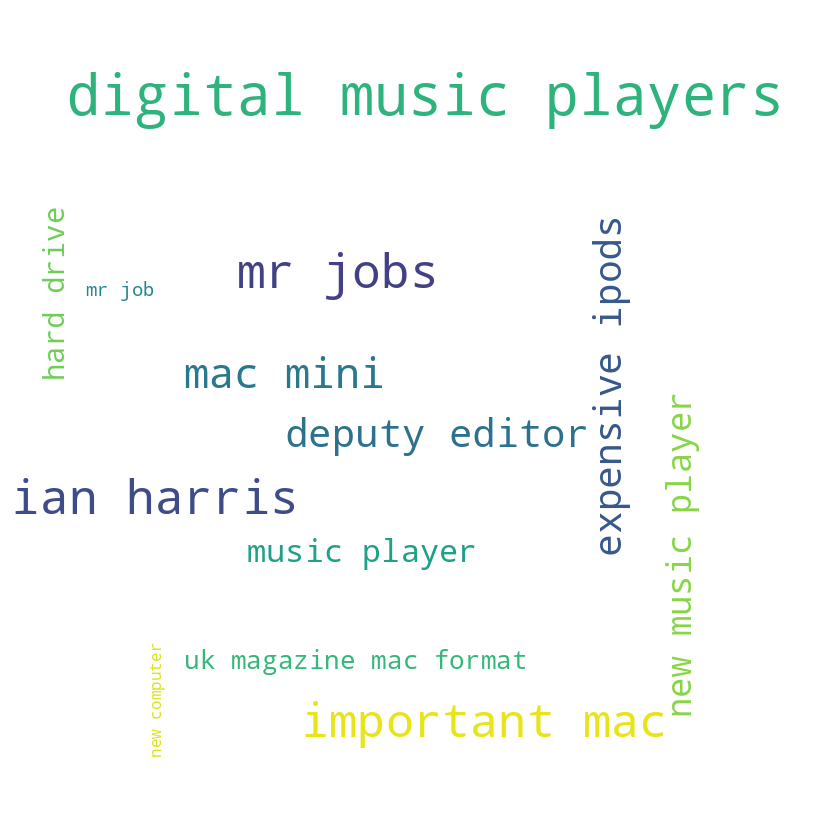

In [98]:
# Draw the word cloud of phrase with shap value > 0
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sum_shap_values = 0 
for shap_value in avg_key_phrases_shap_values.values():
    sum_shap_values += shap_value
word_freq = dict()
for phrase in avg_key_phrases_shap_values: 
    value = avg_key_phrases_shap_values[phrase]
    if value < 0: continue
    word_freq[phrase] = value

wc = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()
